In [1]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor, Compose, Resize
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.nn import Module, NLLLoss, Linear, LogSoftmax, Sequential, Flatten, Dropout, Conv2d
import torchvision.models as models
from torch.optim import Adam
import tqdm

# Prep

In [2]:
device  = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:

train_data = datasets.MNIST(
    root='data',
    train=True,
    transform=ToTensor(),
    download=True,
)

test_data = datasets.MNIST(
    root='data',
    train=False,
    transform=ToTensor()
)

In [4]:
train_data, test_data

(Dataset MNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [5]:
train_data.data.size(), test_data.data.size()

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

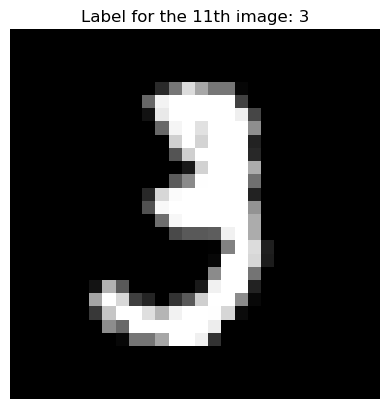

In [17]:
plt.imshow(train_data.data[10], cmap='gray')
plt.title(f'Label for the 11th image: {train_data.targets[10]}')
plt.axis('off')
plt.show()

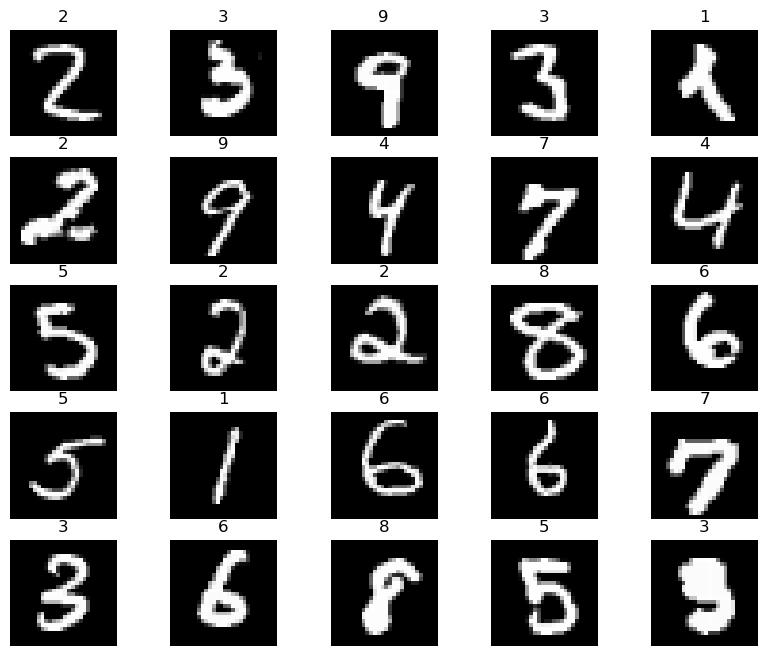

In [20]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [8]:

loaders = {
    'train': torch.utils.data.DataLoader(
        train_data,
        batch_size=100,
        shuffle=True,
        num_workers=1
    ),
    'test': torch.utils.data.DataLoader(
        test_data,
        batch_size=100,
        shuffle=True,
        num_workers=1
    )
}

loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f374d94d6d0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f374da01910>}

# Model

In [9]:
class Classifier(Module):
    def __init__(self, output_size, dropout_rate):
        super(Classifier, self).__init__()

        self.resnet18 = models.resnet18(pretrained=True)
        in_feature = self.resnet18.fc.in_features
        self.resnet18 = Sequential(*list(self.resnet18.children())[:-1])
        self.custom_transform = Conv2d(in_channels=1, out_channels=3, kernel_size=1)
        
        self.transform = Compose([
            self.custom_transform,
            Resize((224, 224)),
        ])

        self.output_size = output_size 
        self.flatten = Flatten(1, -1)
        self.classifier = Linear(in_features=in_feature, out_features=output_size)
        self.dropout_rate = dropout_rate
        self.regularizer = Dropout(self.dropout_rate)
        self.clf_func = LogSoftmax(dim=-1)

    def forward(self, x):
        # x = torch.stack([self.transform(i) for i in x])
        x = self.transform(x)
        hidden = self.resnet18(x)
        hidden = self.flatten(hidden)
        
        hidden = self.classifier(hidden)
        hidden = self.regularizer(hidden)
        return self.clf_func(hidden)

In [10]:
def train(model, x, y, optimizer, loss_fn):
    model.train()

    optimizer.zero_grad()

    y_hat = model(x)

    loss = loss_fn(y_hat, y)

    loss.backward()

    optimizer.step()

    return loss.item()


@torch.no_grad()
def eval(model, x, y):
    model.eval()

    y_hat = model(x)
    # print(y_hat.argmax(-1))
    # print(y)
    return (y_hat.argmax(-1) == y).float().mean()

In [11]:
model = Classifier(10, 0.2).to(device)
optimizer = Adam(model.parameters(), lr=1e-3)
loss_fn = NLLLoss()
num_epochs = 10
losses = []
accs = []

eval_acc = []
for x, y in loaders['test']:
    acc = eval(model, x.to(device), y.to(device))
    eval_acc.append([acc * 100])
acc = torch.tensor(eval_acc).mean()
print(acc)
accs.append(acc)


for epoch in range(num_epochs):
    epoch_loss = 0
    for x, y in tqdm.tqdm(loaders['train']):
        epoch_loss += train(model, x.to(device), y.to(device), optimizer, loss_fn)
    print(epoch, epoch_loss)
    losses.append(epoch_loss)
    eval_acc = []
    for x, y in loaders['test']:
        acc = eval(model, x.to(device), y.to(device))
        eval_acc.append([acc * 100])
    acc = torch.tensor(eval_acc).mean()
    print(acc)
    accs.append(acc)

/home/mastaraan/anaconda3/envs/new/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mastaraan/anaconda3/envs/new/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/mastaraan/anaconda3/envs/new/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1695392026823/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


tensor(7.0700)


100%|██████████| 600/600 [03:27<00:00,  2.89it/s]

0 158.24521958827972


tensor(98.)


100%|██████████| 600/600 [03:27<00:00,  2.89it/s]

1 135.29736529290676


tensor(99.3600)


100%|██████████| 600/600 [03:27<00:00,  2.89it/s]

2 129.29914438724518


tensor(98.8200)


100%|██████████| 600/600 [03:27<00:00,  2.89it/s]

3 127.10922182351351


tensor(99.3600)


100%|██████████| 600/600 [03:27<00:00,  2.89it/s]

4 127.11663220822811


tensor(99.3000)


100%|██████████| 600/600 [03:27<00:00,  2.89it/s]

5 122.79259792715311


tensor(99.3900)


100%|██████████| 600/600 [03:27<00:00,  2.89it/s]

6 121.39696051925421


tensor(99.4100)


100%|██████████| 600/600 [03:27<00:00,  2.89it/s]

7 118.19311721622944


tensor(99.3500)


100%|██████████| 600/600 [03:27<00:00,  2.89it/s]

8 122.27394609153271


tensor(99.2800)


100%|██████████| 600/600 [03:27<00:00,  2.89it/s]

9 119.24641665071249


tensor(99.0400)


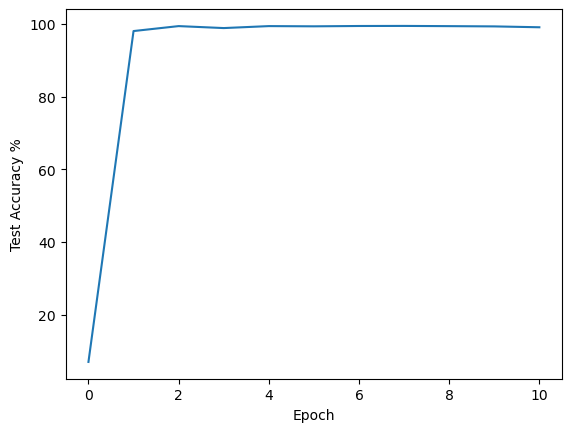

In [13]:
plt.plot(torch.arange(len(accs)).numpy(), torch.tensor(accs).numpy())
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy %')
plt.show()

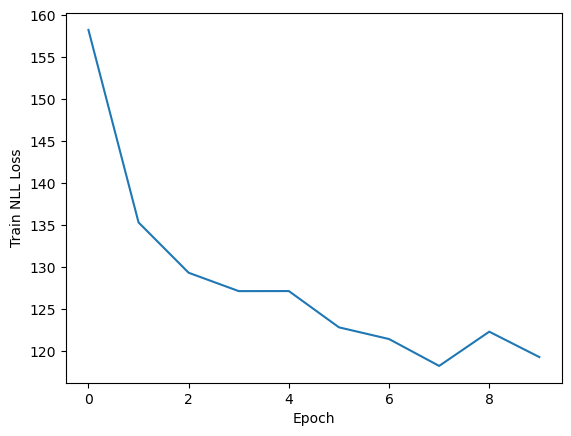

In [15]:
plt.plot(torch.arange(len(losses)).numpy(), torch.tensor(losses).numpy())
plt.xlabel('Epoch')
plt.ylabel('Total Train NLL Loss')
plt.show()